https://www.tensorflow.org/tutorials/keras/basic_classification

https://github.com/Zackory/Keras-MNIST-GAN/blob/master/mnist_gan.py


In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import mnist
from keras.optimizers import Adam, SGD, Adamax
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('th')

from keras.layers.advanced_activations import LeakyReLU

Using TensorFlow backend.


In [2]:
tr_im = np.loadtxt("reals.dat")

In [3]:
tr_im.shape

(20000, 4000)

In [4]:
nrow,ncol = 80,50

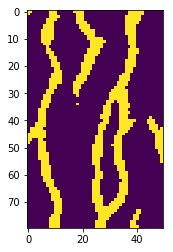

In [5]:
plt.imshow(tr_im[0,:].reshape((nrow,ncol)))

In [6]:
npar = 200 #number of standard normal deviates to feed to generator input

In [7]:
#opt = tf.train.AdamOptimizer(learning_rate=0.0005,beta1=0.5)
opt = Adam(lr=0.0002,beta_1=0.5)

In [8]:
tr_im.max(),tr_im.min()

(1.0, 0.0)

In [9]:
generator = Sequential()
generator.add(Dense(npar*8*5, input_shape=(npar,), kernel_initializer=keras.initializers.RandomNormal(stddev=0.002)))
generator.add(LeakyReLU(0.2))
generator.add(Reshape((npar, 8, 5)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(256, kernel_size=3, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(128, kernel_size=3, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(Conv2D(64, kernel_size=3, padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(5, 5)))
generator.add(Conv2D(1, kernel_size=3, padding='same', activation='sigmoid'))
generator.compile(loss='binary_crossentropy', optimizer=opt)
#generator.summary()


In [10]:
# Discriminator
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=3, strides=(2, 2), padding='same', input_shape=(1, 80, 50), kernel_initializer=initializers.RandomNormal(mean=0.5,stddev=0.002)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(128, kernel_size=3, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.35))
discriminator.add(Conv2D(256, kernel_size=3, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Conv2D(512, kernel_size=3, strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.45))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=opt)
#discriminator.summary()

In [11]:
discriminator.trainable = False
gi = Input(shape=(npar,))
x = generator(gi)
go = discriminator(x)
gan = Model(inputs=gi,outputs=go)
gan.compile(loss="binary_crossentropy",optimizer=opt)

InternalError: Blas GEMM launch failed : a.shape=(10, 200), b.shape=(200, 8000), m=10, n=8000, k=200
	 [[{{node dense_1/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](_arg_dense_1_input_0_0/_51, dense_1/kernel/read)]]
	 [[{{node conv2d_4/Sigmoid/_53}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_111_conv2d_4/Sigmoid", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

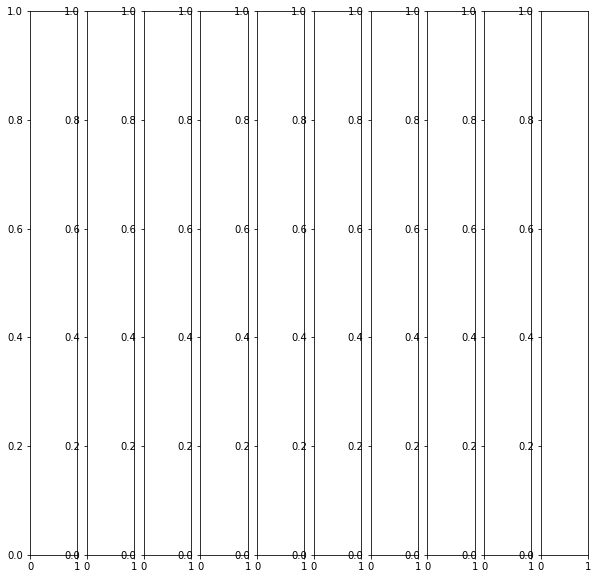

In [12]:

def plot_gen():
    fig, axes = plt.subplots(nrows=1,ncols=10,figsize = (10,10))
    plot_noise = np.random.randn(10,npar) 
    vecs = generator.predict(plot_noise)#.reshape(10,28,28)
    #print(vecs[0,:])
    isreal = discriminator.predict(vecs)
    #print(isreal.shape)
    for ax,vec,real in zip(axes.flatten(),vecs.reshape(10,nrow,ncol),isreal.flatten()):
        ax.imshow(vec)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_title("{0:1.3G}".format(real))
plot_gen()
#generator.save("test.h5")
o_d = "gen_models"
if os.path.exists(o_d):
    shutil.rmtree(o_d)
os.mkdir(o_d)

In [ ]:
batch_size = 256
assert batch_size % 2 == 0
half_batch_size = int(batch_size / 2)
batch_count = int(tr_im.shape[0] / batch_size)
print(batch_count)
plot_gen()
plt.show()
for e in range(1,100):
    for bc in range(batch_count):
        noise = np.random.randn(half_batch_size,npar)
        tr_im_batch = tr_im[np.random.randint(0,tr_im.shape[0],size=half_batch_size)]
        gen_im = generator.predict(noise)
        tr_im_batch = np.resize(tr_im_batch,(half_batch_size,1,nrow,ncol))
        #print(gen_im.shape,tr_im_batch.shape)
        tr_im_batch = np.concatenate([tr_im_batch,gen_im])
        #noisy labels and flipped labels...
        tr_im_lab = np.zeros(batch_size)
        if False:#np.random.rand(1) <= 0.025:
            tr_im_lab[half_batch_size:] = np.random.uniform(0.9,1.0,size=half_batch_size)
            tr_im_lab[:half_batch_size] = np.random.uniform(0.0,0.1,size=half_batch_size)
        else:
            tr_im_lab[:half_batch_size] = np.random.uniform(0.9,1.0,size=half_batch_size)
            tr_im_lab[half_batch_size:] = np.random.uniform(0.0,0.1,size=half_batch_size)
        if True:# bc % 5 == 0:
            discriminator.trainable = True
            dloss = discriminator.train_on_batch(tr_im_batch,tr_im_lab)
        noise = np.random.randn(batch_size,npar)
        tr_img_lab = np.ones(batch_size)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise,tr_img_lab)
        print(bc,gloss,dloss,end="\r")
    if e % 1 == 0:
        print(e,gloss,dloss)
        plot_gen()
        plt.show()
        generator.save(os.path.join(o_d,"gen_{0}.h5").format(e))
        
    